In [2]:
%%capture
!pip install mujoco==2.3.3

In [3]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## **Importing Required Libraries**

This cell imports essential libraries for implementing and visualizing Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). The key components include:


In [4]:
from   torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.distributions import Normal
import random
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym



is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

## **Logging, Visualization, and Video Playback Functions**


In [5]:
def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Replay Memory for Experience Replay**

This class implements a **Replay Buffer**, a crucial component in off-policy reinforcement learning algorithms like DDPG and SAC. The buffer stores past experiences and allows the agent to sample them randomly, breaking correlation between consecutive samples and improving learning stability.

In [6]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## **Neural Networks for DDPG and SAC**

This cell defines key neural networks used in **Deep Deterministic Policy Gradient (DDPG)** and **Soft Actor-Critic (SAC)** algorithms.


- **`GaussianPolicy`**: A stochastic policy for SAC, using Gaussian action sampling.
- **`DeterministicPolicy`**: A deterministic actor for DDPG, applying action bounds.

In [7]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        # TODO 1 -> Define two separate Q-networks (Q1 and Q2) for twin Q-learning.
        self.linear1_q1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2_q1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3_q1 = nn.Linear(hidden_dim, 1)

        self.linear1_q2 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2_q2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3_q2 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        # TODO 2 -> Concatenate state and action as input and compute Q-values for both Q-networks.
        xu = torch.cat([state, action], dim=-1)

        x1 = F.relu(self.linear1_q1(xu))
        x1 = F.relu(self.linear2_q1(x1))
        Q1 = self.linear3_q1(x1)

        x2 = F.relu(self.linear1_q2(xu))
        x2 = F.relu(self.linear2_q2(x2))
        Q2 = self.linear3_q2(x2)

        return Q1, Q2


LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        # TODO 3 -> Compute action scaling and shifting factors based on the environment's action space.
        self.action_scale = torch.tensor((action_space.high - action_space.low) / 2.0, dtype=torch.float32)
        self.action_bias = torch.tensor((action_space.high + action_space.low) / 2.0, dtype=torch.float32)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        # TODO 4 -> Use the reparameterization trick to sample from the Gaussian policy and apply action bounds.
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # Reparameterization trick
        y_t = torch.tanh(x_t)

        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias

        return action, log_prob, mean


class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        # TODO 5 -> Compute action scaling and shifting factors for deterministic policy.
        self.action_scale = torch.tensor((action_space.high - action_space.low) / 2.0, dtype=torch.float32)
        self.action_bias = torch.tensor((action_space.high + action_space.low) / 2.0, dtype=torch.float32)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        # TODO 6 -> Generate an action by adding noise to the deterministic policy for exploration.
        mean = self.forward(state)
        noise = torch.randn_like(mean) * 0.1  # Add small Gaussian noise for exploration
        action = mean + noise
        action = torch.clamp(action, self.action_scale * -1 + self.action_bias, self.action_scale + self.action_bias)
        return action, torch.tensor(0.), mean


## **Soft Actor-Critic (SAC) Implementation - Explanation of the Cell**

This cell implements the **Soft Actor-Critic (SAC) algorithm**, a state-of-the-art off-policy reinforcement learning method for continuous control. The key idea behind SAC is to maximize both the **expected reward** and the **entropy** of the policy, promoting exploration and robustness.

### **Main Components in This Cell**
1. **Hyperparameters & Configuration**  
   - The algorithm's key parameters such as **discount factor** ($\gamma$), **soft update factor** ($\tau$), and **entropy coefficient** ($\alpha$) are set from the `config` dictionary.
   - **Entropy tuning** is optionally enabled to adjust $\alpha$ dynamically.

2. **Critic (Q-Networks)**
   - Two separate **Q-networks** (`self.critic` and `self.critic_target`) estimate the action-value function.
   - Using **twin Q-learning** (two critics) reduces overestimation bias.

3. **Actor (Policy Network)**
   - **Gaussian policy** is used when `policy_type="Gaussian"`, meaning actions are sampled from a probability distribution instead of being deterministic.
   - The policy is trained to maximize both expected rewards and entropy.
   - If the deterministic version (DDPG-like) is used, entropy is ignored ($\alpha = 0$).

4. **Action Selection (`select_action`)**
   - If `evaluate=False`, actions are sampled from the stochastic policy.
   - If `evaluate=True`, deterministic actions are chosen for testing.

5. **Parameter Update (`update_parameters`)**
   - **Sample a batch** from replay memory.
   - Compute **target Q-values** using the **minimum of the two Q-networks**.
   - Update **critic networks** by minimizing Bellman loss.
   - Update **policy** using the entropy-regularized objective.
   - If entropy tuning is enabled, update **$\alpha$** using.
   - Periodically **soft update** the target Q-network.


In [8]:
class SAC:
    def __init__(self, num_inputs, action_space, config):
        # Initialize hyperparameters
        self.gamma = config['gamma']
        self.tau = config['tau']
        self.alpha = config['alpha']
        self.policy_type = config['policy']
        self.target_update_interval = config['target_update_interval']
        self.automatic_entropy_tuning = config['automatic_entropy_tuning']
        self.device = torch.device("cuda" if config['cuda'] else "cpu")

        # Initialize Critic networks
        self.critic = QNetwork(num_inputs, action_space.shape[0], config['hidden_size']).to(self.device)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=config['lr'])

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], config["hidden_size"]).to(self.device)
        self._sync_target_networks()

        # Initialize Policy networks
        self._initialize_policy_networks(action_space, num_inputs, config)

    def _initialize_policy_networks(self, action_space, num_inputs, config):
        """Initialize the policy network based on the type of policy."""
        if self.policy_type == "Gaussian":
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optimizer = Adam([self.log_alpha], lr=config["lr"])

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optimizer = Adam(self.policy.parameters(), lr=config['lr'])
        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optimizer = Adam(self.policy.parameters(), lr=config['lr'])

    def select_action(self, state, evaluate=False):
        """Choose an action based on the state, either stochastically or deterministically."""
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if evaluate:
            action, _ = self.policy.forward(state)  # Deterministic action
        else:
            action, _, _ = self.policy.sample(state)  # Stochastic action
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        """Perform one update of the model parameters."""
        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        # Calculate the next Q-values using the target network
        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target

        # Compute the Q-value loss (Bellman backup)
        qf1, qf2 = self.critic(state_batch, action_batch)
        qf1_loss = F.mse_loss(qf1, next_q_value)
        qf2_loss = F.mse_loss(qf2, next_q_value)
        total_q_loss = qf1_loss + qf2_loss

        # Update Critic network
        self.critic_optimizer.zero_grad()
        total_q_loss.backward()
        self.critic_optimizer.step()

        # Sample actions for policy loss
        pi, log_pi, _ = self.policy.sample(state_batch)

        # Compute the policy loss using Q-values and entropy
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        policy_loss = (self.alpha * log_pi - min_qf_pi).mean()

        # Update Policy network
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Update alpha (entropy coefficient) if necessary
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone()  # Log alpha for visualization
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha)

        # Update target networks periodically
        if updates % self.target_update_interval == 0:
            self._soft_update_target_networks()

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    def _sync_target_networks(self):
        """Synchronize the target critic network with the current critic network."""
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

    def _soft_update_target_networks(self):
        """Softly update the target critic network using Polyak averaging."""
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)


## **Environment Setup and Initialization for SAC**

This cell sets up the environment and initializes the components needed to train the **Soft Actor-Critic (SAC)** agent.


In [ ]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Gaussian",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## **Training Loop for SAC Agent**

This cell contains the **training loop** for the Soft Actor-Critic (SAC) agent. The loop runs for a set number of episodes, where in each episode, the agent interacts with the environment, collects experiences, and updates its parameters.

Episode: 0, reward: -31.55
Episode: 10, reward: -112.72
Episode: 20, reward: 846.59
Episode: 30, reward: 1285.29
Episode: 40, reward: 2391.1
Episode: 50, reward: 394.84
Episode: 60, reward: 3598.89
Episode: 70, reward: 3747.9
Episode: 80, reward: 4296.65
Episode: 90, reward: 4355.67
Episode: 100, reward: 5206.81
Episode: 110, reward: 5444.87
Episode: 120, reward: 5926.32
Episode: 130, reward: 5924.64
Episode: 140, reward: 6337.59
Episode: 150, reward: 6468.78
Episode: 160, reward: 6593.62
Episode: 170, reward: 6865.97
Episode: 180, reward: 6751.2
Episode: 190, reward: 7187.12
Episode: 200, reward: 7216.13
Episode: 210, reward: 7368.13
Episode: 220, reward: 7656.23
Episode: 230, reward: 7591.69
Episode: 240, reward: 7491.71
Episode: 250, reward: 7605.28
Episode: 260, reward: 7808.89
Episode: 270, reward: 7983.79
Episode: 280, reward: 7991.15
Episode: 290, reward: 8206.69
Episode: 300, reward: 8026.1
Episode: 310, reward: 8466.68
Episode: 320, reward: 8427.29
Episode: 330, reward: 8636.2

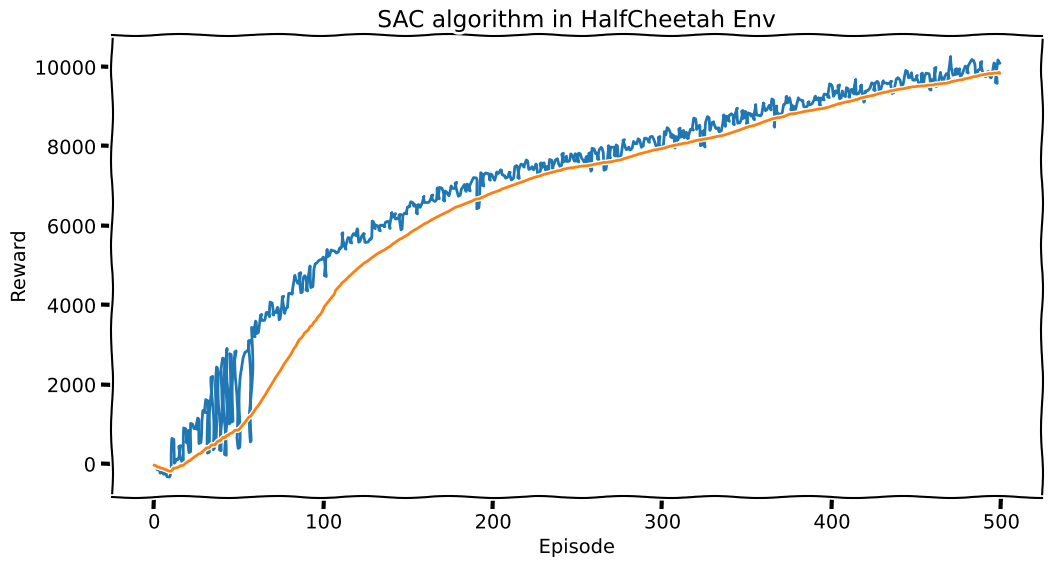

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -1000
for i_episode in range(Max_episodes):
    episode_steps = 0
    done = False
    state, _ = env.reset()

    while not done:
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > config['batch_size']:
              critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
              updates += 1

        next_state, reward, done, truncated, _ = env.step(action) # Step
        episode_steps += 1
        total_numsteps +=1
        done = done or truncated

        # Ignore the "done" signal if it comes from hitting the time horizon.

        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

      # TODO 14: Evaluate the policy at regular intervals and log the average reward.
        pass
      # TODO 14: Here, we are running evaluation episodes to measure how well the policy is performing over time.

      if i_episode % 10 == 0:
        print("Episode: {}, reward: {}".format(i_episode, round(avg_reward, 2)))

      if avg_reward < max_reward:
        criteria +=1
        if criteria == 50:
          break
      else:
        criteria = 0

      max_reward = max(reward_history)

env.close()


plot_rewards(reward_history, show_result='SAC algorithm in HalfCheetah Env')

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
while not done:
    frames.append(env.render())
    action  = agent.select_action(stateوevaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward

    done = done or truncated

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_SAC.mp4', frames, fps=25)
show_video('./eval_SAC.mp4')

# **Initialize DDPG**

In [29]:
# Configuration dictionary
config = {

    "env_name": "HalfCheetah-v4",
    "policy": "DDPG",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": -9**7,
    "seed": 123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "exploration_noise": 0.1,
    "policy_freq": 2,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




# **Train the DDPG here**

Episode: 0, Avg Reward: -181.06
Episode: 50, Avg Reward: 3108.23
Episode: 100, Avg Reward: 4007.06
Episode: 150, Avg Reward: 5013.52
Episode: 200, Avg Reward: 5529.92
Episode: 250, Avg Reward: 6801.31
Episode: 300, Avg Reward: 7452.28
Episode: 350, Avg Reward: 7988.83
Episode: 400, Avg Reward: 8231.84
Episode: 450, Avg Reward: 7651.87


<ipython-input-5-12218de9f29c>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))


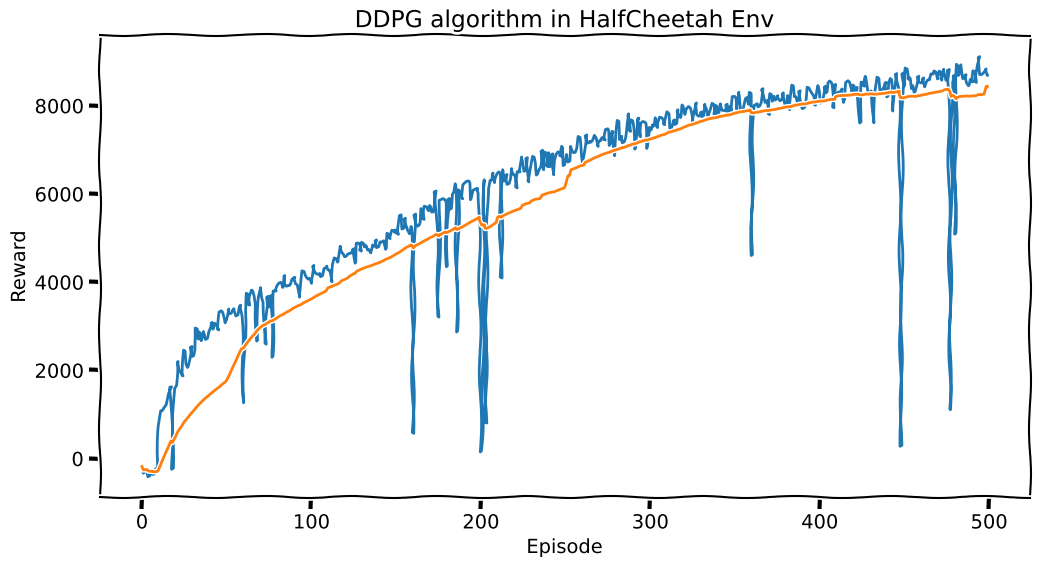

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [31]:
# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -1000

for i_episode in range(Max_episodes):
    episode_steps = 0
    done = False
    state, _ = env.reset()
    episode_reward = 0  # Track episode reward

    while not done:
        # Exploration vs exploitation
        if total_numsteps < config['start_steps']:
            action = env.action_space.sample()  # Random action for exploration
        else:
            action = agent.select_action(state)  # Action selected by the policy

        next_state, reward, done, truncated, _ = env.step(action)  # Step in the environment
        episode_reward += reward  # Accumulate reward in the episode
        episode_steps += 1
        total_numsteps += 1
        done = done or truncated  # Mark episode as done if truncated or finished

        # Handling truncated episodes by masking the done signal
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask)  # Store the transition in memory
        state = next_state

        # Update agent parameters when sufficient memory is collected
        if len(memory) > config['batch_size']:
            critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(
                memory, config['batch_size'], updates
            )
            updates += 1

    reward_history.append(episode_reward)  # Add the episode reward to the history

    # Periodically evaluate the policy performance
    if i_episode % 50 == 0:
        avg_reward = np.mean(reward_history[-10:])  # Calculate average reward of last 10 episodes
        print(f"Episode: {i_episode}, Avg Reward: {round(avg_reward, 2)}")



    max_reward = max(reward_history)  # Update the maximum reward encountered

env.close()

# Plot the rewards over time
plot_rewards(reward_history, show_result="DDPG algorithm in HalfCheetah Env")


In [36]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
for _ in range(1000) :
    frames.append(env.render())
    action  = agent.select_action(state, evaluate=False)
    next_state, reward, _, _, _  = env.step(action)
    total_reward += reward

    state = next_state


env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_DDPG.mp4', frames, fps=25)
show_video('./eval_DDPG.mp4')

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Total Reward: 8680.974516238084
